# TORCHAUDIO 이용 음성 인식

In [1]:
!pip install -q pydub

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

from torchaudio.datasets import SPEECHCOMMANDS
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


데이터 세트 가져오기
---------------------

torchaudio를 사용하여 데이터 세트를 다운로드하고 나타냅니다. 여기에서는 서로 다른 사람들이 말한 35 개 명령의 데이터세트 인 SpeechCommands 를 사용 합니다.  SPEECHCOMMANDS는 이 데이터세트의 torch.utils.data.Dataset 버전입니다. 이 데이터세트에서 모든 오디오 파일의 길이는 약 1 초입니다 (따라서 약 16000 time frame 길이 / 16kHz(16,000Hz)).

실제 로딩 및 포맷 단계는 데이터 포인트에 액세스 할 때 발생하며 torchaudio는 오디오 파일을 텐서로 변환합니다. 오디오 파일을 직접로드하려면torchaudio.load()를 사용할 수 있습니다. 오디오 파일의 샘플링 주파수 (SpeechCommands의 경우 16kHz)와 함께 새로 생성된 텐서를 포함하는 튜플을 반환합니다.

데이터 세트로 돌아가서 training, validation, testing 하위 집합으로 분할하는 subclass를 만듭니다.

In [26]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

# SubsetSC 클래스는 SPEECHCOMMANDS 데이터셋을 상속하여,
# 학습, 테스트, 검증용 하위 집합으로 나누기 위한 클래스
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        # 부모 클래스(SPEECHCOMMANDS)를 호출하며 데이터셋을 다운로드함
        super().__init__("./", download=True)

        # 파일에서 리스트를 로드하는 함수
        def load_list(filename):
            # 파일 경로를 설정
            filepath = os.path.join(self._path, filename)
            # 파일을 열어 각 줄에 있는 파일 경로를 리스트로 변환
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        # 검증용 데이터셋을 로드할 경우
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        # 테스트용 데이터셋을 로드할 경우
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        # 학습용 데이터셋을 로드할 경우
        elif subset == "training":
            # 검증 및 테스트 리스트에서 제외할 항목들을 설정
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            # 학습용 데이터는 검증 및 테스트 데이터에 포함되지 않은 파일들로 구성
            self._walker = [w for w in self._walker if w not in excludes]

# 학습과 테스트 데이터를 생성. 이 튜토리얼에서는 검증 데이터를 사용하지 않음
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

# 학습 데이터셋의 첫 번째 항목을 가져옴 (waveform, 샘플링 레이트, 레이블, 화자 ID, 발화 번호)
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

waveform.shape, sample_rate, label, speaker_id, utterance_number

(torch.Size([1, 16000]), 16000, 'backward', '0165e0e8', 0)

SPEECHCOMMANDS 데이터 세트의 데이터 포인트는 파형 (오디오 신호), 샘플 속도, 발화 (레이블), 화자의 ID, 발화 수로 구성된 튜플입니다.

### torchaudio  사용

Text(0.5, 1.0, 'backward')

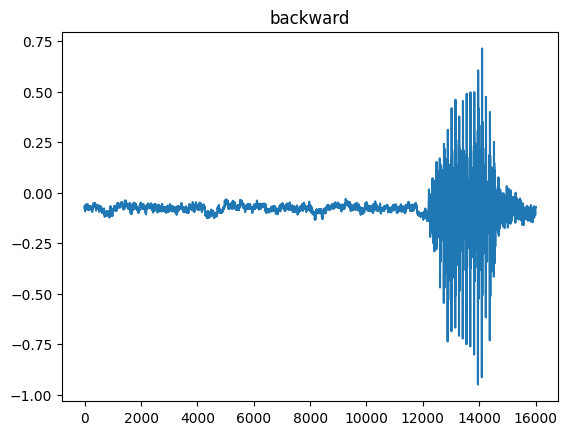

In [17]:
plt.plot(waveform.t().numpy())
plt.title(label)

데이터 세트에서 사용할 수있는 라벨 목록을 찾아 보겠습니다.

In [18]:
len(train_set), len(test_set)

(84843, 11005)

오디오 레이블은 사용자가 말하는 명령입니다.

In [32]:
%%time
labels = sorted(list(datapoint[2] for datapoint in train_set))
print(labels)

['backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'backward', 'ba

In [51]:
from collections import Counter

print(len(Counter(labels)))
print(Counter(labels))

35
Counter({'zero': 3250, 'five': 3240, 'yes': 3228, 'seven': 3205, 'nine': 3170, 'one': 3140, 'down': 3134, 'no': 3130, 'stop': 3111, 'two': 3111, 'go': 3106, 'six': 3088, 'on': 3086, 'left': 3037, 'eight': 3033, 'right': 3019, 'off': 2970, 'three': 2966, 'four': 2955, 'up': 2948, 'house': 1727, 'wow': 1724, 'dog': 1711, 'marvin': 1710, 'bird': 1697, 'cat': 1657, 'happy': 1632, 'sheila': 1606, 'bed': 1594, 'tree': 1407, 'backward': 1346, 'visual': 1288, 'learn': 1286, 'follow': 1275, 'forward': 1256})


In [35]:
waveform_first, sample_rate, label, *_ = train_set[0]
print(label)
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

backward


In [23]:
waveform_second, sample_rate, label, *_ = train_set[1]
print(label)
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

backward


In [27]:
waveform_second, sample_rate, label, *_ = train_set[2]
print(label)
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

backward


In [31]:
waveform_last, sample_rate, label, *_ = train_set[-1]
print(label)
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

zero


데이터 포맷
-------------------

파형의 경우 분류 능력을 너무 많이 잃지 않고 빠른 처리를 위해 오디오를 다운 샘플링합니다.

In [38]:
# 새로운 샘플링 속도를 8000Hz로 설정
new_sample_rate = 8000

# 원래 샘플링 속도에서 새로운 샘플링 속도로 오디오를 리샘플링하는 변환 설정
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)

# 파형(waveform)에 리샘플링 변환을 적용하여 변환된 파형 생성
transformed = transform(waveform_second)

# 리샘플링된 오디오를 새로운 샘플링 속도로 재생
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

레이블 목록의 색인을 사용하여 각 단어를 인코딩합니다.

In [43]:
labels.index('backward'), labels.index('zero'), labels.index('yes')

(0, 81593, 78365)

In [44]:
def label_to_index(word):
    # 레이블에서 단어 index를 tensor로 반환
    return torch.tensor(labels.index(word))

def index_to_label(index):
    # 레이블의 인덱스에 해당하는 단어를 반환
    return labels[index]

word = "yes"
index = label_to_index(word)

# label --> index --> label 변환
print(word, "-->", index.numpy(), "-->", index_to_label(index))

yes --> 78365 --> yes


오디오 녹음 및 발화로 구성된 데이터 포인트 목록을 모델에 대한 두 개의 일괄 텐서로 전환하기 위해 데이터 세트를 일괄적으로 반복할 수 있는 PyTorch DataLoader에서 사용하는 데이터 정렬 함수를 구현합니다.

CNN 모델은 주로 입력 형식으로 (batch_size, in_channels, sequence_length)를 요구합니다.
이 경우, permute(0, 2, 1)을 사용하면 시퀀스 차원과 특징 차원(feature_size)을 교환하여 CNN이 요구하는 입력 형식 (batch_size, feature_size, sequence_length)로 맞출 수 있습니다.

In [48]:
a = torch.ones(15, 300)  # 크기 (15, 300)인 텐서 생성, 모든 값이 1로 초기화됨
b = torch.ones(20, 300)  # 크기 (20, 300)인 텐서 생성, 모든 값이 1로 초기화됨
c = torch.ones(5, 300)    # 크기 (5, 300)인 텐서 생성, 모든 값이 1로 초기화됨

# 세 개의 텐서를 패딩하여 동일한 길이로 맞춘 배치 생성
# batch_first=True를 설정하면 배치 크기가 첫 번째 차원이 됨, padding_value=0. 으로 0을 사용해 패딩
padded_batch = torch.nn.utils.rnn.pad_sequence([a, b, c], batch_first=True, padding_value=0.)

# 패딩된 배치의 크기 출력
print(padded_batch.size())

# 패딩된 배치의 차원을 변환하여 두 번째 차원과 세 번째 차원을 교환한 크기 출력
print(padded_batch.permute(0, 2, 1).size())

torch.Size([3, 20, 300])
torch.Size([3, 300, 20])


- batch shape 은 nn.Conv1d의 입력에 맞추어 $(N, C_{\text{in}}, L)$으로 출력  
- N: batch size, C: channels, L: sequence length

In [49]:
def pad_sequence(batch):
    # 0으로 패딩하여 배치 내의 모든 텐서를 동일한 길이로 만듭니다.
    batch = [item.t() for item in batch]  # 각 텐서를 전치하여 차원 변경
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)  # 0으로 패딩하여 시퀀스 길이 맞춤
    return batch.permute(0, 2, 1)  # 텐서의 차원을 (배치, 채널, 시퀀스 길이)로 변환

def collate_fn(batch):
    # 데이터 튜플의 형식:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # 리스트로 데이터를 모으고, 레이블을 인덱스로 인코딩
    for waveform, _, label, *_ in batch:
        tensors += [waveform]  # 파형(waveform)을 수집
        targets += [label_to_index(label)]  # 레이블을 인덱스로 변환하여 수집

    # 텐서 리스트를 배치 텐서로 그룹화
    tensors = pad_sequence(tensors)  # 패딩 처리된 시퀀스
    targets = torch.stack(targets)          # 레이블들을 하나의 텐서로 묶음

    return tensors, targets  # 배치 텐서와 레이블 반환

batch_size = 256  # 배치 크기 설정

# GPU를 사용할 경우 관련 설정
if device == "cuda":
    num_workers = 1  # 데이터를 로드하는 워커 수 설정
    pin_memory = True  # 데이터를 GPU로 전송하는 속도를 향상시키기 위한 옵션
else:
    num_workers = 0  # CPU를 사용할 경우 워커 수를 0으로 설정
    pin_memory = False  # 메모리 핀 설정을 비활성화

# 학습 데이터 로더 설정
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,  # 배치 크기 설정
    shuffle=True,  # 데이터를 무작위로 섞어서 로드
    collate_fn=collate_fn,  # 데이터 배치를 위한 collate 함수 설정
    num_workers=num_workers,  # 워커 수 설정
    pin_memory=pin_memory,  # 메모리 핀 설정
)

# 테스트 데이터 로더 설정
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,  # 배치 크기 설정
    shuffle=False,  # 데이터를 섞지 않고 순서대로 로드
    collate_fn=collate_fn,  # 데이터 배치를 위한 collate 함수 설정
    num_workers=num_workers,  # 워커 수 설정
    pin_memory=pin_memory,  # 메모리 핀 설정
)

네트워크 정의
------------------

원시 오디오 데이터를 처리하기 위해 컨벌루션 신경망을 사용.   
일반적으로 더 고급 변환이 오디오 데이터에 적용되지만 CNN을 사용하여 원시 데이터를 정확하게 처리 할 수 있습니다.


In [53]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        """
        n_input=1: 입력 채널 수: 모노 1, 스테레오(좌, 우) 신호 2
        n_output=35:  출력 레이어의 출력 차원, 즉 클래스의 개수
        stride=16: 커널이 한 번 적용된 후 16개의 타임스텝을 건너뛰어 다음 위치에 적용. 계산량을 줄이는 데 도움
        n_channel=32: 각 컨볼루션 레이어의 출력 채널 수
        """
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print(f"Number of parameters: {n:,}")

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=84843, bias=True)
)
Nu

가중치 감소가 0.0001로 설정된 Adam 옵티마이저를 사용. 처음에는 0.01의 학습률로 훈련하지만 scheduler20 에포크 이후 훈련 중에 ``scheduler`` 를 사용 하여 0.001로 줄입니다.

In [54]:
# weight decay: L2 패널티를 적용 (가중치 감쇠)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

# 학습률 스케줄러 설정
# step_size 에포크마다 gamma 비율로 학습률을 감소시킴
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

네트워크 훈련 및 테스트
--------------------------------

이제 훈련 데이터를 모델에 공급하고 backpropagation 및 optimization 단계를 수행하는 training 함수를 정의해 보겠습니다. 훈련을 위해 우리가 사용할 손실은 negative log-likelihood입니다. 그런 다음 각 Epoch 후에 네트워크를 테스트하여 훈련 중에 정확도가 어떻게 달라지는지 확인합니다.

In [55]:
def train(model, epoch, log_interval):
    model.train()  # 모델을 학습 모드로 설정
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)  # 데이터를 GPU 또는 CPU로 전송
        target = target.to(device)  # 타겟(레이블)을 GPU 또는 CPU로 전송

        # device에서 직접 전체 배치에 변환 및 모델 적용
        data = transform(data)  # 데이터를 변환 적용
        output = model(data)  # 모델에 데이터를 입력하여 출력 생성

        # (batch x 1 x n_output)에 대한 negative log-likelihood 손실 계산
        loss = F.nll_loss(output.squeeze(), target)  # 손실 함수 계산 (출력과 타겟 비교)

        optimizer.zero_grad()  # 이전에 계산된 변화도를 모두 초기화
        loss.backward()  # 손실에 대한 역전파 수행
        optimizer.step()  # 가중치 업데이트

        # 학습 통계 출력
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} \
            ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # 진행 상황 바 업데이트
        pbar.update(pbar_update)
        # 손실 기록
        losses.append(loss.item())

이제 training 함수가 있으므로 네트워크 정확도를 테스트하기 위한 함수를 만들어야합니다. 모델을 eval()모드로 설정한 다음 테스트 데이터세트에서 추론을 실행합니다. eval()을 호출하여 네트워크의 모든 모듈에서 훈련 변수를 false로 설정합니다. 배치 정규화 및 드롭 아웃 레이어와 같은 특정 레이어는 훈련 중에 다르게 작동하므로 이 단계는 올바른 결과를 얻는 데 중요합니다.

In [57]:
def number_of_correct(pred, target):
    # 정확한 예측의 개수를 셈
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # 배치 내 각 요소에 대해 가장 가능성 높은 라벨 인덱스를 찾음
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0  # 정확한 예측 수를 저장할 변수

    with torch.inference_mode():
        for data, target in test_loader:
    
            data = data.to(device)  # 데이터를 GPU 또는 CPU로 전송
            target = target.to(device)  # 타겟(레이블)을 GPU 또는 CPU로 전송
    
            # device에서 직접 전체 배치에 변환 및 모델 적용
            data = transform(data)  # 데이터에 변환을 적용
            output = model(data)  # 모델에 데이터를 입력하여 출력 생성
    
            pred = get_likely_index(output)  # 가장 가능성 높은 예측값을 가져옴
            correct += number_of_correct(pred, target)  # 정확한 예측 개수를 업데이트
    
            # 진행 상황 바 업데이트
            pbar.update(pbar_update)

    # 에포크별 테스트 결과 출력 (정확도)
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} \
                    ({100. * correct / len(test_loader.dataset):.0f}%)\n")

이제 네트워크를 훈련하고 테스트 할 수 있습니다. 우리는 10  Epoch 동안 네트워크를 훈련시킨 다음, 학습률을 줄이고 10 Epoch 더 훈련할 것입니다. 훈련 중 정확도가 어떻게 달라지는지 확인하기 위해 각 Epoch 후에 네트워크를 테스트합니다.

  0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/84843             (0%)]	Loss: 1.021695
Train Epoch: 1 [5120/84843             (6%)]	Loss: 1.073449
Train Epoch: 1 [10240/84843             (12%)]	Loss: 1.092664
Train Epoch: 1 [15360/84843             (18%)]	Loss: 1.017510
Train Epoch: 1 [20480/84843             (24%)]	Loss: 1.190395
Train Epoch: 1 [25600/84843             (30%)]	Loss: 0.956617
Train Epoch: 1 [30720/84843             (36%)]	Loss: 1.105942
Train Epoch: 1 [35840/84843             (42%)]	Loss: 0.949751
Train Epoch: 1 [40960/84843             (48%)]	Loss: 1.071472
Train Epoch: 1 [46080/84843             (54%)]	Loss: 0.946433
Train Epoch: 1 [51200/84843             (60%)]	Loss: 1.092102
Train Epoch: 1 [56320/84843             (66%)]	Loss: 0.908901
Train Epoch: 1 [61440/84843             (72%)]	Loss: 0.945497
Train Epoch: 1 [66560/84843             (78%)]	Loss: 1.007251
Train Epoch: 1 [71680/84843             (84%)]	Loss: 0.967303
Train Epoch: 1 [76800/84843             (90%)]	Loss: 0.851368
Train Epoch: 1 

Text(0.5, 1.0, 'training loss')

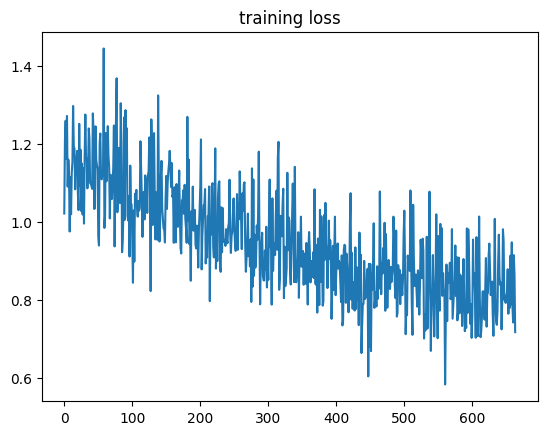

In [58]:
log_interval = 20  # 학습 통계를 출력할 간격 설정
n_epoch = 2  # 학습할 총 에포크 수 설정

pbar_update = 1 / (len(train_loader) + len(test_loader))  # 진행 상황 바 업데이트 비율 계산
losses = []  # 손실 값을 저장할 리스트

transform = transform.to(device)  # 변환(transform)을 모델 및 데이터와 동일한 장치(device)로 이동

# tqdm을 사용하여 진행 상황 표시
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)  # 각 에포크마다 학습 함수 호출
        test(model, epoch)  # 각 에포크마다 테스트 함수 호출
        scheduler.step()  # 스케줄러 업데이트 (학습률 조정)

# 학습 손실을 반복 횟수에 따라 시각화
plt.plot(losses)
plt.title("training loss")  # 학습 손실에 대한 그래프 제목 설정

네트워크는 2 Epoch 후에 테스트 세트에서 65 % 이상, 21 Epoch 후에 85 % 이상 정확해야합니다. train 세트의 마지막 단어를보고 모델이 어떻게했는지 살펴 보겠습니다.

In [59]:
def predict(tensor):
    # 모델을 사용하여 파형의 레이블을 예측
    tensor = tensor.to(device)  # 텐서를 GPU 또는 CPU로 이동
    tensor = transform(tensor)  # 변환 적용
    tensor = model(tensor.unsqueeze(0))  # 배치 차원을 추가한 후 모델에 입력하여 예측 수행
    tensor = get_likely_index(tensor)  # 가장 가능성 높은 예측 라벨 인덱스 추출
    tensor = index_to_label(tensor.squeeze())  # 인덱스를 라벨로 변환
    return tensor         # 예측된 라벨 반환


# 학습 세트에서 마지막 항목의 파형(waveform), 샘플링 속도, 발화(utterance) 가져오기
waveform, sample_rate, utterance, *_ = train_set[-1]

# 오디오 재생 (파형을 numpy 배열로 변환하고 샘플링 속도 설정)
ipd.Audio(waveform.numpy(), rate=sample_rate)

# 예측된 결과와 실제 발화 출력
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


올바르게 분류되지 않은 예를 찾아 보겠습니다.

In [60]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    # 파형을 예측하여 출력값을 생성
    output = predict(waveform)

    # 예측값이 실제 발화(utterance)와 다를 경우
    if output != utterance:
        # 오디오 재생 (파형을 numpy 배열로 변환하고 샘플링 속도를 적용하여 재생)
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        # 잘못 분류된 데이터 포인트와 예측 결과 출력
        print(f"데이터 포인트 #{i}. 예상: {utterance}. 예측: {output}.")
        break  # 잘못된 예측이 나오면 반복을 종료
    else:
        # 모든 예시가 올바르게 분류된 경우 출력
        print("이 데이터셋의 모든 예시는 올바르게 분류되었습니다!")
        # 잘못된 예시가 없을 경우 마지막 데이터 포인트를 출력
        print("이 경우 마지막 데이터 포인트를 살펴보겠습니다")
        # 마지막 데이터 포인트의 오디오 재생
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        # 마지막 데이터 포인트의 예상 발화와 예측된 결과 출력
        print(f"데이터 포인트 #{i}. 예상: {utterance}. 예측: {output}.")

이 데이터셋의 모든 예시는 올바르게 분류되었습니다!
이 경우 마지막 데이터 포인트를 살펴보겠습니다
데이터 포인트 #0. 예상: right. 예측: right.
데이터 포인트 #1. 예상: right. 예측: three.
